# ✍️ MNIST Digit Recognizer – Sketch Your Digits!

Welcome to the **MNIST Digit Recognizer**! This app allows you to draw a digit (0–9) directly in your browser and predicts what digit you sketched using a trained deep learning model.

## 🚀 How to Use

1. **Open the link for the running server on a huggingface space**
  - [Try the app here!](https://ahmed-amer-mnist-gradio.hf.space/?__theme=light)

2. **Sketch Your Digit**
   - Click on the **🖌️ Brush icon** located on the **left side** of the sketchpad.
   - Use your mouse or touchscreen to **draw a digit** (0 through 9) inside the sketch area.
   - Make sure to draw clearly, using most of the canvas for better recognition.

3. **Submit Your Drawing**
   - After drawing, simply **wait a moment** and the model will automatically predict your digit.
   - You'll see the prediction results below the canvas with the probabilities for each digit.

4. **Clear the Sketchpad**
   - To erase your sketch and start over, **click the trash can 🗑️ icon** on the **top-right corner** of the canvas.
   - ⚠️ Do **not** use any additional "Clear" button — just the one on the canvas!

## 🧠 Behind the Scenes

This app uses a TensorFlow-trained neural network to classify handwritten digits. The drawing is preprocessed into a 28x28 grayscale image before being fed to the model.




---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Necessary Libraries**

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import warnings
from warnings import filterwarnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore")

# **Load the Dataset**

In [13]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# **Understand And Organize the Datase**

In [14]:
# Check data types
print(f"x_train data type: {type(x_train)}")
print(f"y_train data type: {type(y_train)}")
print(f"x_test data type: {type(x_test)}")
print(f"y_test data type: {type(y_test)}\n")

# Check shapes of the datasets
print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}\n")

# Check unique values in target variables
print(f"Unique values in y_train: {np.unique(y_train)}")
print(f"Unique values in y_test: {np.unique(y_test)}\n")

# Check if there is any missing data
print(f"Any missing values in x_train: {np.any(np.isnan(x_train))}")
print(f"Any missing values in y_train: {np.any(np.isnan(y_train))}")
print(f"Any missing values in x_test: {np.any(np.isnan(x_test))}")
print(f"Any missing values in y_test: {np.any(np.isnan(y_test))}")

x_train data type: <class 'numpy.ndarray'>
y_train data type: <class 'numpy.ndarray'>
x_test data type: <class 'numpy.ndarray'>
y_test data type: <class 'numpy.ndarray'>

x_train shape: (60000, 28, 28)
y_train shape: (60000,)
x_test shape: (10000, 28, 28)
y_test shape: (10000,)

Unique values in y_train: [0 1 2 3 4 5 6 7 8 9]
Unique values in y_test: [0 1 2 3 4 5 6 7 8 9]

Any missing values in x_train: False
Any missing values in y_train: False
Any missing values in x_test: False
Any missing values in y_test: False


***How many different label values do we have?***

In [15]:
num_labels = len(np.unique(y_train))
num_labels

10

## **Frequency Distribution of Target Labels y_train and y_test**

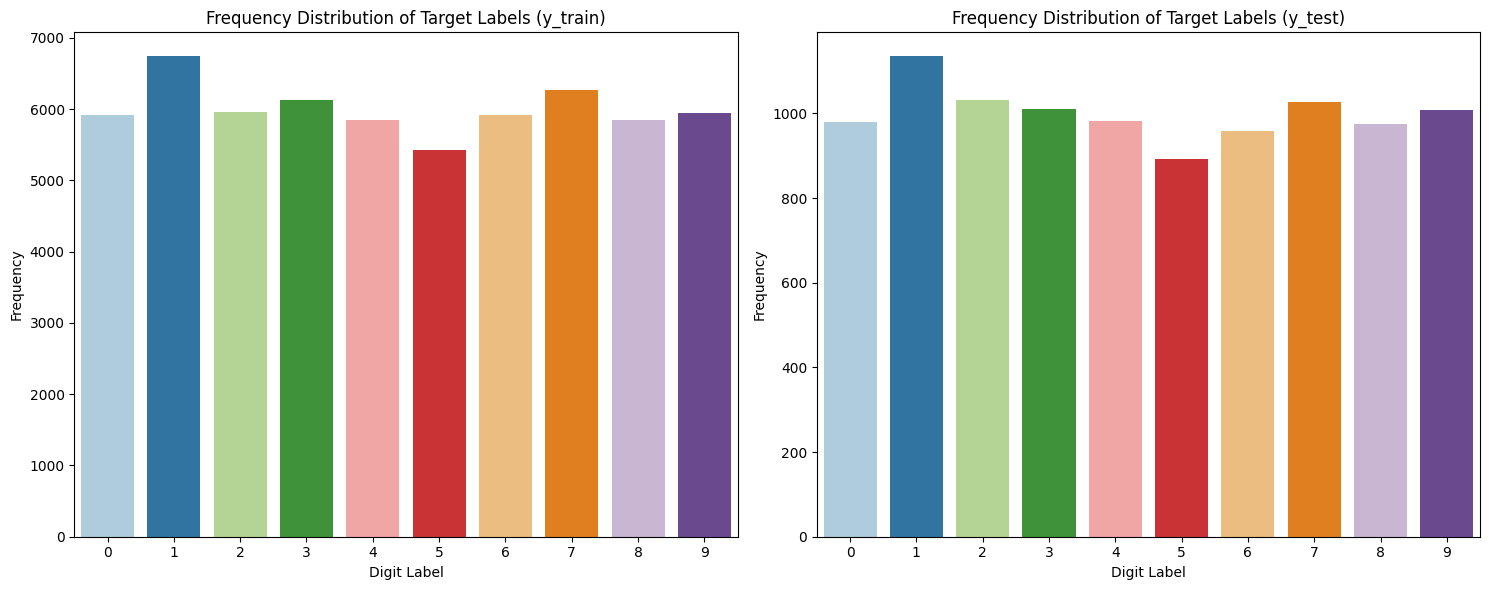

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.countplot(x=y_train, palette='Paired', ax=axes[0])
axes[0].set_title('Frequency Distribution of Target Labels (y_train)')
axes[0].set_xlabel('Digit Label')
axes[0].set_ylabel('Frequency')

sns.countplot(x=y_test, palette='Paired', ax=axes[1])
axes[1].set_title('Frequency Distribution of Target Labels (y_test)')
axes[1].set_xlabel('Digit Label')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## **Visualization of Some Digits and Their Labels**

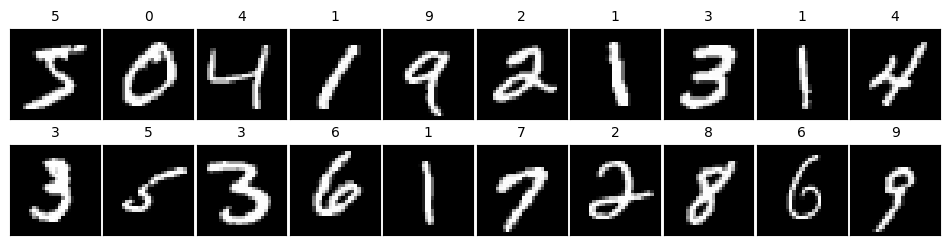

In [17]:
def visualize_images(data):
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(12,3),
                             gridspec_kw={'wspace':0.04, 'hspace':0.01},
                             squeeze=True)

    for i, ax in enumerate(axes.flat):
        ax.imshow(x_train[i], cmap='gray')
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_title(str(y_train[i]), fontsize=10)

    plt.tight_layout()
    plt.show()

visualize_images(x_train)

## **Visualizing an Image with Pixel Values**

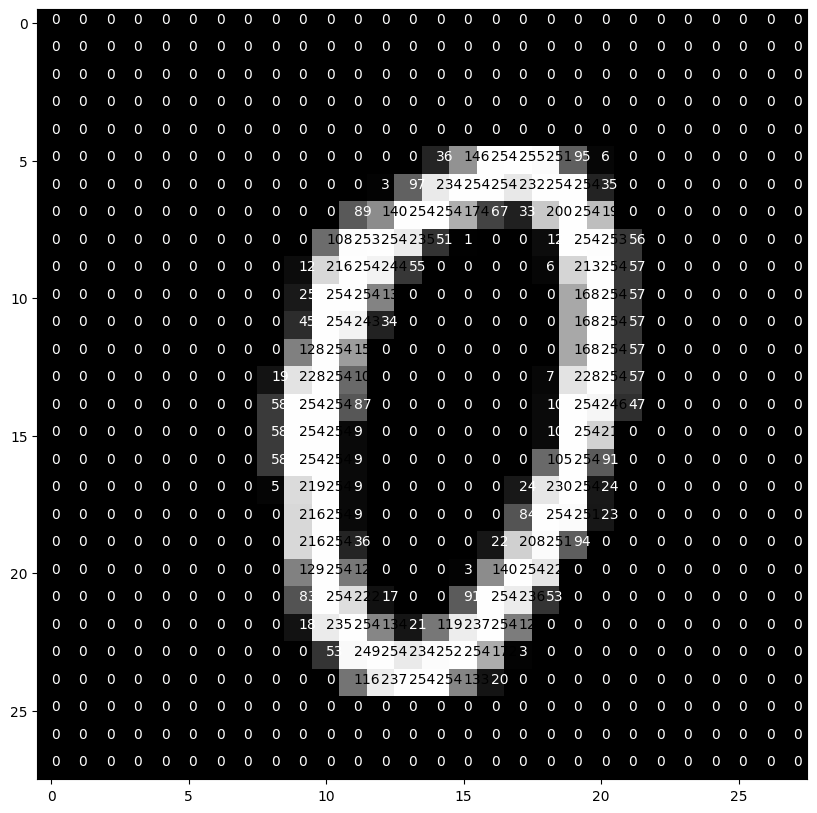

In [18]:
def pixel_visualize(img):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    ax.imshow(img, cmap="gray")
    width, height = img.shape
    threshold = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y], 2)), xy=(y,x),
                       color='white' if img [x][y]<threshold else 'black')

pixel_visualize(x_train[1000])

##  **Preprocessing**

In [19]:
y_train[0:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

In [20]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [21]:
y_train[0:10]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [22]:
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)


In [23]:
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255

# **Model Building**

In [24]:
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "accuracy"])

In [25]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 13, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 5, 5, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       819,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 892,266 (3.40 MB)

 Trainable params: 891,050 (3.40 MB)

 Non-trainable params: 1,216 (4.75 KB)

## **Using ImageDataGenerator**

In [26]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(x_train)

## **EarlyStopping**

In [27]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
history = model.fit(datagen.flow(x_train, y_train, batch_size=512), epochs=50,
                    validation_data=(x_test, y_test), callbacks=[early_stopping])

Epoch 1/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5602 - loss: 1.5433 - precision: 0.6389 - recall: 0.4993 - val_accuracy: 0.1135 - val_loss: 4.5545 - val_precision: 0.1135 - val_recall: 0.1135
Epoch 2/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 218s 2s/step - accuracy: 0.9015 - loss: 0.3185 - precision: 0.9221 - recall: 0.8856 - val_accuracy: 0.1177 - val_loss: 5.4000 - val_precision: 0.1170 - val_recall: 0.1167
Epoch 3/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9352 - loss: 0.2070 - precision: 0.9480 - recall: 0.9257 - val_accuracy: 0.2170 - val_loss: 3.1940 - val_precision: 0.2418 - val_recall: 0.2105
Epoch 4/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 222s 2s/step - accuracy: 0.9507 - loss: 0.1620 - precision: 0.9595 - recall: 0.9437 - val_accuracy: 0.7870 - val_loss: 0.5836 - val_precision: 0.8824 - val_recall: 0.7337
Epoch 5/50
118/118 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.9592 - loss: 0.1360 - precision: 0.9657 - recall: 0.9529 - val_accuracy: 0.9837 - val_los

# **Results and Visualization of the Model**

In [28]:
y_pred = model.predict(x_test)
y_pred_class = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step


## **Classification Report**

In [29]:
class_labels = ['0','1','2','3','4','5','6','7','8','9']
report = classification_report(y_true, y_pred_class, target_names=class_labels)
print(report)

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       1.00      0.99      1.00      1032
           3       0.99      1.00      1.00      1010
           4       0.99      1.00      0.99       982
           5       1.00      0.99      0.99       892
           6       1.00      0.99      0.99       958
           7       0.99      1.00      0.99      1028
           8       0.99      1.00      0.99       974
           9       1.00      0.99      1.00      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



## **Train & Test Accuracy and Loss**

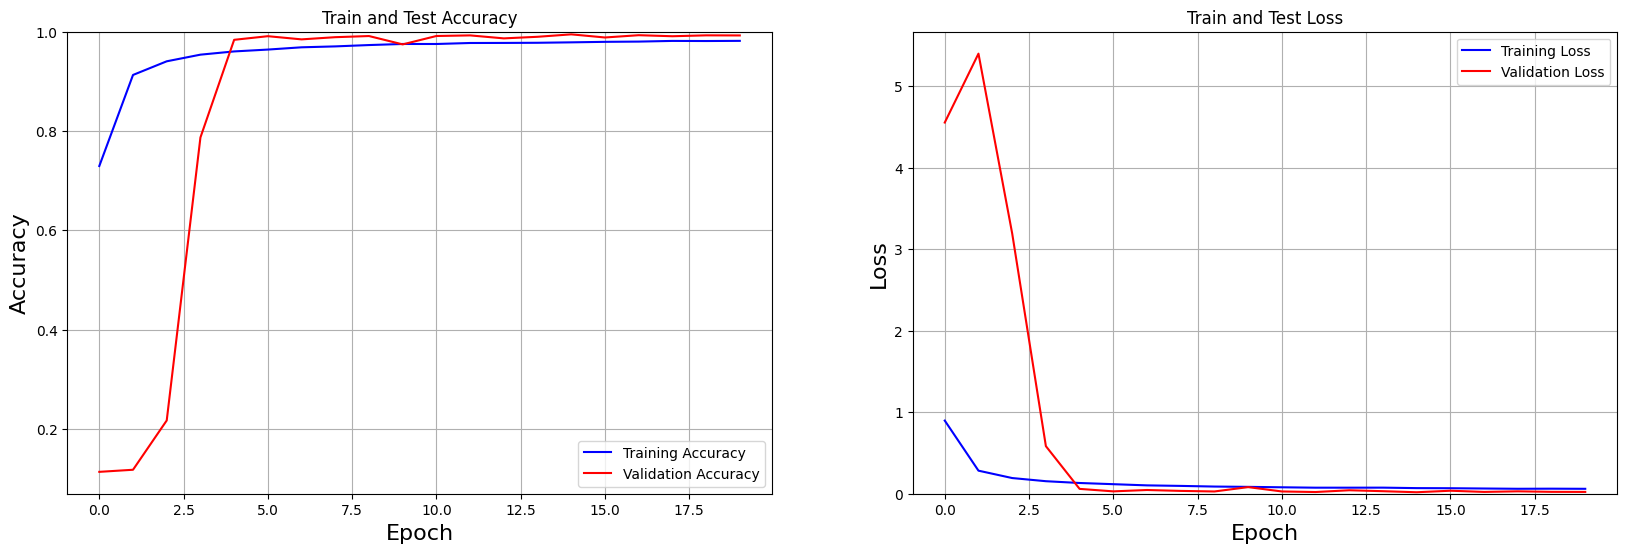

In [30]:
plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], color='b', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], color='r', label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()),1])
plt.title('Train and Test Accuracy')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history.history['loss'], color='b', label='Training Loss')
plt.plot(history.history['val_loss'], color='r', label='Validation Loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Train and Test Loss')
plt.grid(True)
plt.show()

In [31]:
loss, precision, recall, acc=model.evaluate(x_test, y_test, verbose=False)
print('Test Accuracy: ', acc)
print('Test Loss: ', loss)
print('Test Precision: ', precision)
print('Test Recall: ', recall)

Test Accuracy:  0.994700014591217
Test Loss:  0.0181571114808321
Test Precision:  0.9949960112571716
Test Recall:  0.9941999912261963


# **Model Saving**

In [32]:
model.save('mnist_model.h5')

# **Testing Results**

In [33]:
import random
random = random.randint(0, x_test.shape[0])
random

1767

In [34]:
test_image = x_test[random]
y_test[random]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

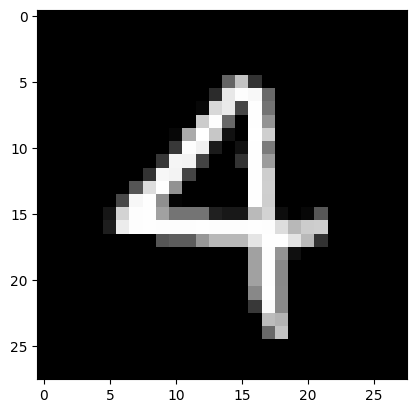

In [35]:
plt.imshow(test_image.reshape(28,28), cmap='gray');

In [36]:
test_data = x_test[random].reshape(1,28,28,1)
probability = model.predict(test_data)
probability

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


array([[1.0730404e-10, 1.9905042e-09, 4.2749533e-09, 5.6172914e-14,
        9.9996555e-01, 1.9392716e-13, 4.2200643e-10, 3.4176090e-05,
        5.2743943e-09, 1.8197042e-07]], dtype=float32)

In [37]:
predicted_classes = np.argmax(probability)
predicted_classes

np.int64(4)

In [38]:
print(f'Predicted class: {predicted_classes}')
print(f'Predicted class probability value: {(np.argmax(probability, axis=-1))[0]}')
print(f'Probability values of other classes: \n{probability}')

Predicted class: 4
Predicted class probability value: 4
Probability values of other classes: 
[[1.0730404e-10 1.9905042e-09 4.2749533e-09 5.6172914e-14 9.9996555e-01
  1.9392716e-13 4.2200643e-10 3.4176090e-05 5.2743943e-09 1.8197042e-07]]


# **Misclassified Samples**

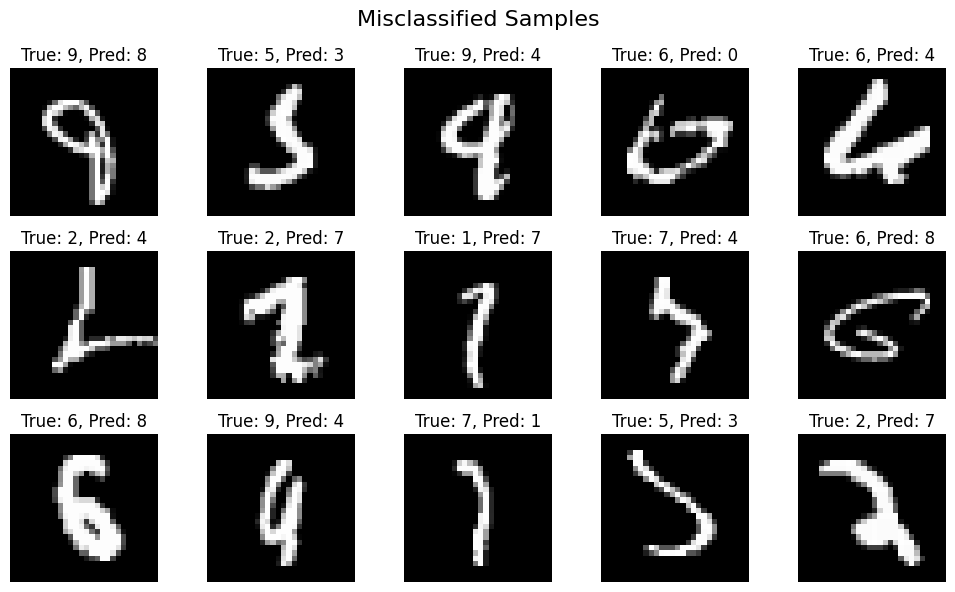

In [39]:
y_test_labels = np.argmax(y_test, axis=1)

misclassified_idx = np.where(y_pred_class != y_test_labels)[0]

fig, axes = plt.subplots(3, 5, figsize=(10, 6))
fig.suptitle("Misclassified Samples", fontsize=16)

for i, ax in enumerate(axes.flat):
    idx = misclassified_idx[i]
    ax.imshow(x_test[idx].reshape(28, 28), cmap="gray")
    ax.set_title(f"True: {y_test_labels[idx]}, Pred: {y_pred_class[idx]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# **Classification Accuracy Per Digit**

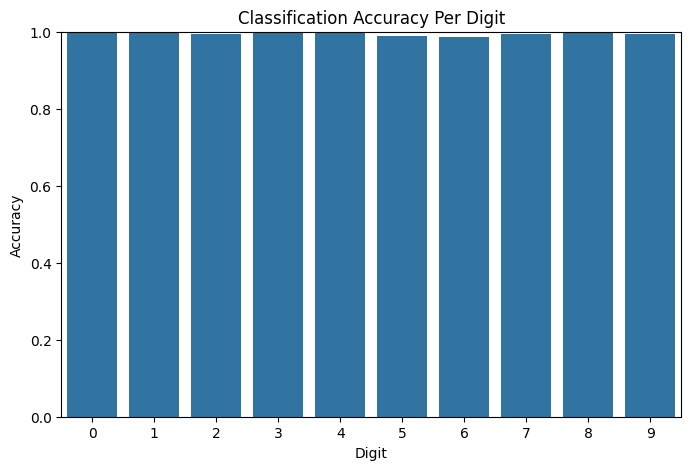

In [40]:
num_classes = 10
class_accuracies = []

for i in range(num_classes):
    correct = np.sum((y_test_labels == i) & (y_pred_class == i))
    total = np.sum(y_test_labels == i)
    accuracy = correct / total if total > 0 else 0
    class_accuracies.append(accuracy)

df = pd.DataFrame({"Digit": range(10), "Accuracy": class_accuracies})

plt.figure(figsize=(8, 5))
sns.barplot(x="Digit", y="Accuracy", data=df)
plt.ylim(0, 1)
plt.xlabel("Digit")
plt.ylabel("Accuracy")
plt.title("Classification Accuracy Per Digit")
plt.show()

# **Confusion Matrix**

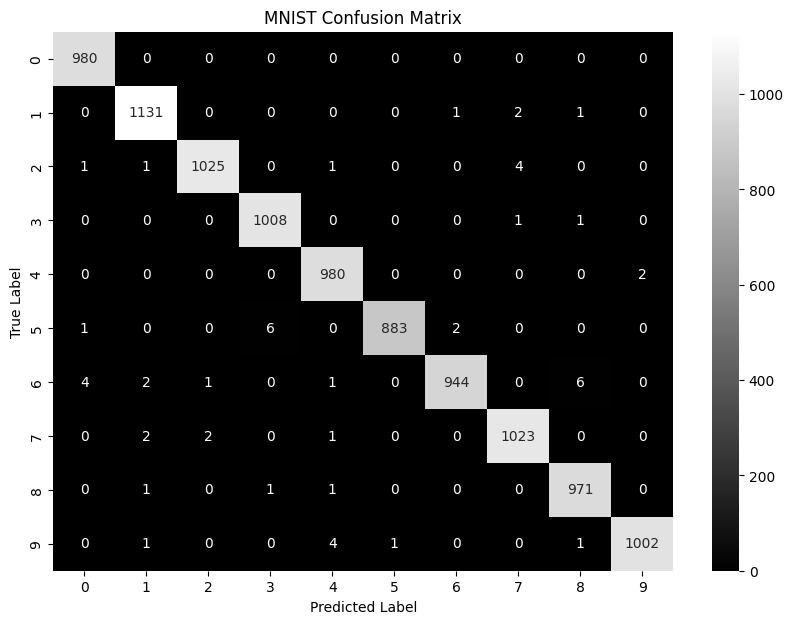

In [41]:
y_pred_labels = y_pred_class
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="gray", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MNIST Confusion Matrix")
plt.show()



---



## Gradio application

In [42]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 63.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.8 MB/s eta 0:00:00


In [43]:
import tensorflow as tf
import gradio as gr
import numpy as np
from PIL import Image, ImageOps

model = tf.keras.models.load_model('mnist_model.h5')

def sketchToNumpy(image):
    if image is None or "composite" not in image:
        return "No image provided"

    im_array = image["composite"]

    pil_img = Image.fromarray(im_array).convert("L")
    pil_img = ImageOps.invert(pil_img)
    pil_img = pil_img.resize((28, 28))

    img_resized = np.array(pil_img).astype("float32") / 255.0

    img_input = img_resized.reshape(1, 28, 28, 1)

    prediction = model.predict(img_input)

    return {str(i): float(prediction[0][i]) for i in range(10)}

demo = gr.Interface(
    fn=sketchToNumpy,
    inputs=gr.Sketchpad(crop_size=(256, 256), type='numpy', image_mode='L'),
    outputs=gr.Label(num_top_classes=10, label="Prediction"),
)

demo.launch(debug=True)


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://875049d1dc0ace768f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://875049d1dc0ace768f.gradio.live


### Here is the link for the running server
- https://ahmed-amer-mnist-gradio.hf.space/?__theme=light&deep_link=tDSJdvOKJLU